University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  

# Week 2 exercises

## 1. Permutation testing (6 pts)

We will use permutation testing to study if the mother's age (`age`) affects the birth weight (`bwt`) of their babies. We will use the absolute difference in the means as the test statistic. We will focus the analysis on full term pregnancies (`gestation >= 273`).

*Note*: When reporting a $p$-value for $b$ more extreme tests out of $m$, use $p = (b+1)/(m+1)$ to avoid zero p-values. 50000 permutations will be sufficient for obtaining the required accuracy.

1. Load the data set below. Test whether the birth weights (`bwt`) of babies with young (`age < 26`) and older (`age >= 26`) mothers are statistically significantly different using the difference of the means as the test statistic. Report the $p$-value you obtain in Moodle.
2. Stratify the analysis by the variable smoking status of the mothers by splitting to separate smoker (`smoke = 0`) and non-smoker (`smoke = 1`) groups. Constrain the permutations so that only changes within each group are allowed. After the permutation, merge the two groups back together to compute the means. Report the $p$-value you obtain in Moodle.

In [2]:
import pandas as pd
import numpy as np
from typing import Callable

rng = np.random.default_rng(42)
# Load the data set
babies_full = pd.read_csv("https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/babies2.txt", sep='\t')

# Pick a subset
babies1: pd.DataFrame = babies_full.iloc[(babies_full['gestation']>=273).values]


In [3]:
def shuffle(x1, x2):
    """Return a random reshuffling of elements in two arrays."""
    n1 = len(x1)
    z = rng.permutation(np.concatenate((x1, x2)))
    return z[0:n1], z[n1:]

def permutation_test(x1: np.ndarray, x2: np.ndarray, n_perm: int = 50000) -> float:
    population_diff = np.abs(np.mean(x1) - np.mean(x2))
    permutation_diff = np.zeros(n_perm)
    for i in range(n_perm):
        z1, z2 = shuffle(x1, x2)
        permutation_diff[i] = np.abs(np.mean(z1) - np.mean(z2))
    return (np.sum(population_diff <= permutation_diff) + 1) / (n_perm + 1)


def stratified_permutation_test(x1a: np.ndarray, x2a: np.ndarray, x1b: np.ndarray, x2b: np.ndarray, n_perm: int = 50000) -> float:
    permutation_diff = np.zeros(n_perm)
    population_diff = np.abs(np.concatenate((x1a, x1b)).mean() - np.concatenate((x2a, x2b)).mean())
    for i in range(n_perm):
        z1a, z2a = shuffle(x1a, x2a) # mix of older and young mothers who smoke
        z1b, z2b = shuffle(x1b, x2b) # mix of older and young mothers who don't smoke
        z1 = np.concatenate((z1a, z1b))
        z2 = np.concatenate((z2a, z2b))
        permutation_diff[i] = np.abs(z1.mean() - z2.mean())
    return (np.sum(population_diff <= permutation_diff) + 1) / (n_perm + 1)



In [4]:
young_mothers_bwt = babies1.query('age < 26')['bwt'].values
older_mothers_bwt = babies1.query('age >= 26')['bwt'].values
print("Does the age of the mother affect the birth weight of the baby? p-value:", permutation_test(young_mothers_bwt, older_mothers_bwt))

Does the age of the mother affect the birth weight of the baby? p-value: 0.07335853282934342


In [5]:
young_mothers_smokers_bwt = babies1.query('age < 26 and smoke == 1')['bwt'].values
older_mothers_smokers_bwt = babies1.query('age >= 26 and smoke == 1')['bwt'].values
young_mothers_non_smokers_bwt = babies1.query('age < 26 and smoke == 0')['bwt'].values
older_mothers_non_smokers_bwt = babies1.query('age >= 26 and smoke == 0')['bwt'].values

print("Does the age of the mother affect the birth weight of the baby, controlled by smoking? stratified p-value:", 
    stratified_permutation_test(young_mothers_smokers_bwt, older_mothers_smokers_bwt, young_mothers_non_smokers_bwt, older_mothers_non_smokers_bwt)
    )

Does the age of the mother affect the birth weight of the baby, controlled by smoking? stratified p-value: 0.07933841323173536


## 2. Bootstrap confidence intervals on data statistics (4 pts)

In this exercise we use bootstrap to estimate confidence intervals for various quantities. (Using 1000 bootstrap samples will give you enough accuracy assuming everything is correctly done.)

1. Use bootstrap to estimate the central 95% confidence interval for the mean of `bwt` in the *full* data set loaded in Problem 1. Report the lower and upper ends of the interval in Moodle.
2. Use bootstrap to estimate the central 95% confidence interval for the mean of `bwt` in the smaller subset (`gestation >= 273`) of the data set used in Problem 1. Report the lower and upper ends of the interval in Moodle.
3. Use bootstrap to estimate the central 95% confidence interval for the correlation coefficient of `gestation` and `age` in the full data set loaded in Problem 1. What does this tell about the relation between the duration of the pregnancy and the age of the mother? Report the bounds of the interval in Moodle.
4. Use bootstrap to estimate the central 95% confidence interval for the correlation coefficient of `gestation` and `age` in the smaller subset (`gestation >= 273`) used in Problem 1. What does this tell about the relation between the duration of the pregnancy and the age of the mother? Report the bounds of the interval in Moodle.

*Hint*: Remember that the size of the bootstrap sample is always the same as the size of the original data set.

In [71]:
n_bootstrap_samples = 1_000

#2.1
birth_weights_all = babies_full['bwt'].to_numpy()
birth_weights_full_bootstrapped_means = rng.choice(birth_weights_all, size=(n_bootstrap_samples, len(birth_weights_all)), replace=True).mean(axis=1)
birth_weights_full_mean_ci = np.quantile(birth_weights_full_bootstrapped_means, [0.025, 0.975])
print(f"95% CI for the mean birth weight of all mothers: {birth_weights_full_mean_ci}")

#2.2
birth_weights_full_term = babies1['bwt'].to_numpy()
birth_weights_full_term_bootstrapped_means = rng.choice(birth_weights_full_term, size=(n_bootstrap_samples, len(birth_weights_full_term)), replace=True).mean(axis=1)
birth_weights_full_term_mean_ci = np.quantile(birth_weights_full_term_bootstrapped_means, [0.025, 0.975])
print(f"95% CI for the mean birth weight of term mothers: {birth_weights_full_term_mean_ci}")

#2.3
corrcoef_bootstraps = np.zeros(n_bootstrap_samples)
age_ = babies_full['age'].to_numpy()
gestation_ = babies_full['gestation'].to_numpy()
assert len(age_) == len(gestation_)
n = len(age_)
for i in range(n_bootstrap_samples):
    indices = rng.choice(n, n, replace=True)
    corrcoef_bootstraps[i] = np.corrcoef(age_[indices], gestation_[indices])[0, 1]
print(f"95% CI for the correlation coefficient between age and gestation: {np.quantile(corrcoef_bootstraps, [0.025, 0.975])}")

#2.4
corrcoef_bootstraps = np.zeros(n_bootstrap_samples)
age_ = babies1['age'].to_numpy()
gestation_ = babies1['gestation'].to_numpy()
assert len(age_) == len(gestation_)
n = len(age_)
for i in range(n_bootstrap_samples):
    indices = rng.choice(n, n, replace=True)
    corrcoef_bootstraps[i] = np.corrcoef(age_[indices], gestation_[indices])[0, 1]
print(f"95% CI for the correlation coefficient between age and gestation: {np.quantile(corrcoef_bootstraps, [0.025, 0.975])}")


95% CI for the mean birth weight of all mothers: [118.42689685 120.50419864]
95% CI for the mean birth weight of term mothers: [122.46066092 124.56014368]
95% CI for the correlation coefficient between age and gestation: [-0.10477816  0.00422615]
95% CI for the correlation coefficient between age and gestation: [-0.09040178  0.03347546]


## 3. Bootstrap confidence intervals on parameter estimates (4 pts)

In this task, we will use bootstrap to obtain confidence intervals on maximum likelihood parameter estimates for linear regression models. We will apply simple case resampling, i.e. resampling the individuals and then fitting the model using the data $(x_i, y_i)$ from these individuals. There are alternative methods that may work better when the data are limited, but in our case there are enough observations so that this will not be a problem. 1000 bootstrap samples will again give you enough accuracy.

A linear regression fit to scalar $x_i, y_i$ involves fitting the model
$$ y_i = \alpha + \beta x_i + \epsilon_i, $$
where $\beta$ is the regression coefficient and $\alpha$ is the intercept. Assuming $\epsilon_i \sim N(0, \sigma^2)$, the log-likelihood of the model is
$$ \log p(Y | X, \alpha, \beta) = \sum_{i=1}^n \log p(y_i | x_i, \alpha, \beta)
  = \sum_{i=1}^n - \frac{1}{2 \sigma^2} (y_i - \alpha - \beta x_i)^2 + C, $$
where $C$ is independent of $\alpha, \beta$. This is maximised when
$$ \hat{\beta}= \frac{\sum_{i = 1}^n (x_i - \bar{x})(y_i - \bar{y}) }{ \sum_{i = 1}^n (x_i - \bar{x})^2} \\
   \hat{\alpha} = \bar{y} - \hat{\beta} \bar{x},$$
where $\bar{x} = \frac{1}{n} \sum_{i = 1}^n x_i$ and $\bar{y} = \frac{1}{n} \sum_{i = 1}^n y_i$.

1. Implement the above linear regression model to predict `gestation` ($y$) as a function of `age` ($x$) in the full data set. Report the estimated $\beta$ in Moodle.
2. Use bootstrap to estimate the confidence interval of the regression coefficient $\beta$ in the above model by resampling the individuals used to fit the model. Report the lower and upper bounds of the central 95% confidence interval of $\beta$ in Moodle.


In [7]:
import pandas as pd
import numpy as np
import numpy.random as npr

# Load the data set
babies_full = pd.read_csv("https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/babies2.txt", sep='\t')

babies3 = babies_full

age_array = babies3['age'].to_numpy()
gestation_array = babies3['gestation'].to_numpy()

beta_hat = np.sum((age_array - age_array.mean()) * (gestation_array - gestation_array.mean())) / np.sum((age_array - age_array.mean())**2)
alpha_hat = gestation_array.mean() - beta_hat * age_array.mean()
print(f"gestation = {alpha_hat:.2f} + {beta_hat:.2f} * age")
print(f"Beta: {beta_hat}")

def solve_beta_alpha(x: np.ndarray, y: np.ndarray) -> tuple[float, float]:
    beta_hat = np.sum((x - x.mean()) * (y - y.mean())) / np.sum((x - x.mean())**2)
    alpha_hat = y.mean() - beta_hat * x.mean()
    return beta_hat, alpha_hat

def bootstrap_beta(x: np.ndarray, y: np.ndarray, n_bootstraps: int) -> np.ndarray:
    bootstrap_samples = np.zeros(n_bootstraps)
    l = len(x)
    assert len(x) == len(y)
    for i in range(n_bootstraps):
        indices = npr.choice(l, size=l, replace=True)
        x_ = x[indices]
        y_ = y[indices]
        beta_hat, alpha_hat = solve_beta_alpha(x_, y_)
        bootstrap_samples[i] = beta_hat
    return bootstrap_samples

bootstrapped_beta = bootstrap_beta(age_array, gestation_array, 1000)
print(f"95% CI for beta: {np.quantile(bootstrapped_beta, [0.025, 0.975])}")    


gestation = 283.12 + -0.15 * age
Beta: -0.14772779151120377
95% CI for beta: [-0.29008701 -0.00520346]


## 4. Density estimation (6 pts)

1. Estimate the joint density of `bwt` and `age` in the full data set using kernel density estimation with a 2-dimensional Gaussian kernel
$$ K(\mathbf{x}) = \frac{1}{2\pi} \exp\left( - \frac{\|\mathbf{x}\|^2}{2} \right)
 = \frac{1}{2\pi} \exp\left( - \frac{x_1^2 + x_2^2}{2} \right) $$
using bandwidth $h=5$. Report the value of the estimated density at point `bwt=110`, `age=31` in Moodle.

*Hint*: you can verify your results by ploting a 2D histogram of the data (`matplotlib.pyplot.hist2d`) and a contour plot of the estimated density (see e.g. Sec. 5.1.1 in Course notes for a contour plot example).

2. With the Gaussian kernel above, use leave-one-out (LOO) cross validation to find the optimal $h$ in the range `np.linspace(1.0, 5.0, 50)`. The optimal $h$ maximizes the LOO log-likelihood. Report the value of $h$ and the value of the estimated density at `bwt=110`, `age=31` in Moodle.

3. Use $k$-fold cross validation with $k=17$ to find the optimal $h$ in the range `np.linspace(1.0, 5.0, 50)`. Report the value of $h$ and the value of the estimated density at `bwt=110`, `age=31` in Moodle. For this exercise, the sample point indices for the $k$ partitions of the data should consist of consecutive indices, e.g. the first partition should be the data with indices `0:69` and so on. (In practical applications it is generally good practice to randomly permute the indices as well when creating partitions, but don't do it for this exercise.)

In [88]:
def two_dimensional_gaussian_kernel(x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
    xterm = x1**2 + x2**2
    return np.exp(-xterm / 2) / (2 * np.pi)

def kde_two_dimensional(x1: np.ndarray, x2: np.ndarray, x1_range: np.ndarray, x2_range: np.ndarray, h: float) -> np.ndarray:
    n = len(x1)
    if x1_range is not None and x2_range is not None:
        kde = np.zeros((len(x1_range), len(x2_range)))
        for i in range(kde.shape[0]):
            for j in range(kde.shape[1]):
                kde[i, j] = np.sum(two_dimensional_gaussian_kernel((x1_range[i] - x1) / h, (x2_range[j] - x2) / h)) / (n * h**2)
        return kde
    else:
        k = np.zeros(n)
        for i in range(n):
            k[i] = np.sum(two_dimensional_gaussian_kernel((x1[i] - x1) / h, (x2[i] - x2) / h)) / (n * h**2)
        return k

age_array = babies_full['age'].to_numpy()
bwt_array = babies_full['bwt'].to_numpy()

age_range = np.arange(15, 51)
bwt_range = np.arange(60, 180)

result = kde_two_dimensional(age_array, bwt_array, age_range ,bwt_range, 3)

In [89]:
bwt_array.max()

176

(array([[ 0.,  0.,  0.,  0.,  1.,  4.,  1.,  2.,  0.,  0.],
        [ 0.,  1., 10., 17., 27., 29., 24.,  8.,  3.,  2.],
        [ 0.,  3.,  8., 27., 53., 82., 39., 18.,  1.,  1.],
        [ 3.,  3., 12., 30., 54., 59., 54., 17.,  6.,  2.],
        [ 0.,  2.,  7., 23., 42., 58., 43., 20.,  9.,  1.],
        [ 1.,  4.,  6., 17., 24., 35., 34., 11.,  4.,  2.],
        [ 2.,  1.,  4., 14., 17., 28., 19.,  9.,  7.,  1.],
        [ 0.,  4.,  3.,  7., 16., 16., 12.,  6.,  3.,  1.],
        [ 0.,  2.,  2.,  6., 10.,  9.,  9.,  6.,  2.,  1.],
        [ 0.,  0.,  0.,  1.,  2.,  5.,  2.,  1.,  1.,  0.]]),
 array([15., 18., 21., 24., 27., 30., 33., 36., 39., 42., 45.]),
 array([ 55. ,  67.1,  79.2,  91.3, 103.4, 115.5, 127.6, 139.7, 151.8,
        163.9, 176. ]),
 <matplotlib.collections.QuadMesh at 0x7f9e15008fd0>)

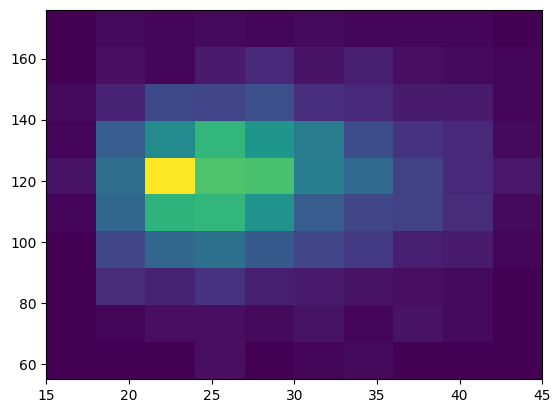

In [90]:
from matplotlib import pyplot as plt
plt.hist2d(age_array, bwt_array)


/tmp/ipykernel_42410/1043664678.py:3: UserWarning: The following kwargs were not used by contour: 'xunits', 'yunits'
  plt.contourf(result.T, cmap='Blues', xunits=xticks, yunits=yticks)


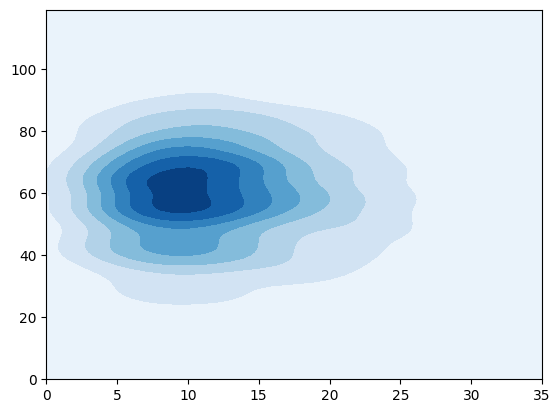

In [91]:
xticks = np.arange(15, 51, 5)
yticks = np.arange(60, 180, 10)
plt.contourf(result.T, cmap='Blues', xunits=xticks, yunits=yticks)

In [92]:
kde_two_dimensional(age_array, bwt_array, np.array([31]), np.array([110]), 5).item()

0.0007101226311425995

In [99]:
def loo_kde_h(x1: np.ndarray, x2: np.ndarray, x1_range: np.ndarray, x2_range: np.ndarray, h_range: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    loo = np.zeros(len(h_range))
    assert x1.shape == x2.shape
    for i, h in enumerate(h_range):
        log_lh = 0
        for j in range(len(x1)):
            x1_ = np.delete(x1, j)
            x2_ = np.delete(x2, j)
            kde = kde_two_dimensional(x1_, x2_, x1_range, x2_range, h)
            log_lh += np.sum(np.log(kde))
        loo[i] = log_lh
        print(f"Log LH for h={h}: {log_lh}")
    return loo, h_range


In [100]:
likelihoods, h_values = loo_kde_h(
    age_array, bwt_array, None, None, h_range=np.linspace(1, 5, 50)
)

Log LH for h=1.0: -9868312.789760549
Log LH for h=1.0816326530612246: -9911435.177325992
Log LH for h=1.163265306122449: -9947733.265705854
Log LH for h=1.2448979591836735: -9978589.903536256
Log LH for h=1.3265306122448979: -10005064.279091606
Log LH for h=1.4081632653061225: -10027982.370169152
Log LH for h=1.489795918367347: -10047997.278474288
Log LH for h=1.5714285714285714: -10065630.564650282
Log LH for h=1.6530612244897958: -10081301.60062702
Log LH for h=1.7346938775510203: -10095349.190884909
Log LH for h=1.816326530612245: -10108048.034777632
Log LH for h=1.8979591836734693: -10119621.59661525
Log LH for h=1.9795918367346939: -10130252.341364734
Log LH for h=2.061224489795918: -10140089.932748087
Log LH for h=2.142857142857143: -10149257.791431066
Log LH for h=2.224489795918367: -10157858.310502045
Log LH for h=2.3061224489795915: -10165976.974607943
Log LH for h=2.387755102040816: -10173685.596460715
Log LH for h=2.4693877551020407: -10181044.855032794
Log LH for h=2.551020

In [101]:
likelihoods.argmax()

0